### CNN 기법을 이용한 안면(얼굴) 인식

In [4]:
# 글꼴 설치전 런타임 환경 확인
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
from google.colab import drive
drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

Mounted at /content/drive


In [5]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/ai_ml/cnn/actor' # Colab

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [6]:
width=64
height=64

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/train', # 파일이 있는 폴더, Colab은 절대 경로 명시해야 인식가능 
        target_size=(width, height), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)
 
vali_generator = vali_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/validation',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 244 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [7]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) 
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/ai_ml/cnn/actor/Actor.h5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=2,
                               restore_best_weights=True)
start = time.time()

hist = model.fit(
    train_generator,
    epochs = 50,
    validation_data = vali_generator, 
    callbacks=[checkpointer, early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# CPU: 
# Colab GPU: 198 초

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


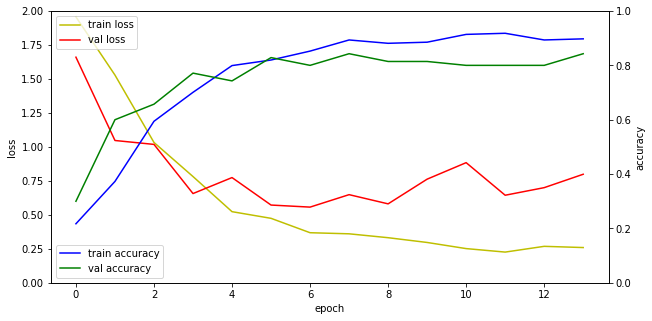

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 2.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [9]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 80.00%


In [10]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 15개, 3개의 분류임으로 출력은 15행 3열
print(output)

-- Predict --
{'Amanda Seyfried': 0, 'Andrew Lincoln': 1, 'Anne Hathaway': 2, 'Hugh Jackman': 3, 'Keira Christina Knightley': 4, 'Pierce Brosnan': 5, 'Zo Jung Seok': 6}
<class 'numpy.ndarray'>
(70, 7)
[[0.001 0.002 0.004 0.000 0.988 0.000 0.006]
 [0.000 0.000 0.001 0.998 0.000 0.000 0.000]
 [0.011 0.000 0.000 0.000 0.013 0.000 0.976]
 [0.001 0.000 0.000 0.009 0.000 0.000 0.990]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000]
 [0.663 0.336 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.028 0.014 0.010 0.426 0.178 0.076 0.268]
 [0.000 0.033 0.966 0.000 0.001 0.000 0.000]
 [0.964 0.007 0.000 0.000 0.020 0.008 0.001]
 [0.004 0.827 0.158 0.002 0.005 0.003 0.000]
 [0.000 0.001 0.999 0.000 0.000 0.000 0.000]
 [0.001 0.000 0.000 0.000 0.023 0.000 0.976]
 [0.000 0.999 0.000 0.000 0.000 0.000 0.000]
 [0.734 0.010 0.001 0.001 0.070 0.154 0.030]
 [0.000 0.999 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.998 0.002 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.

In [14]:
model.save('/content/drive/My Drive/ai_ml/cnn/actor/Actor.h5')

In [16]:
model = load_model('/content/drive/My Drive/ai_ml/cnn/actor/Actor.h5')

In [17]:
def display(data):
    # print(data)
    # print(type(data))
    sw= np.argmax(data)
    # print('sw:', sw)

    if sw == 0:
        sw = 'Amanda Seyfried'
    elif sw == 1:
        sw = 'Andrew Lincoln'
    elif sw == 2:
        sw = 'Anne Hathaway'
    elif sw == 3:
        sw = 'Hugh Jackman'
    elif sw == 4:
        sw = 'Keira Christina Knightley'        
    elif sw == 5:
        sw = 'Pierce Brosnan'   
    elif sw == 6:
        sw = '조정석'
        
    return sw    

In [19]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test1',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Amanda Seyfried /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.996 0.003 0.000 0.000 0.000 0.000 0.000]]
타겟: Amanda Seyfried / Amanda Seyfried


In [20]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test2',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Andrew Lincoln /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.001 0.983 0.001 0.000 0.015 0.000 0.000]]
타겟: Andrew Lincoln / Andrew Lincoln


In [21]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test3',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Anne Hathaway /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 1.000 0.000 0.000 0.000 0.000]]
타겟: Anne Hathaway / Anne Hathaway


In [22]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test4',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Keira Christina Knightley /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.002 0.002 0.003 0.001 0.945 0.035 0.011]]
타겟: Keira Christina Knightley / Keira Christina Knightley


In [23]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test5',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Pierce Brosnan /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.005 0.027 0.002 0.002 0.055 0.908 0.001]]
타겟: Pierce Brosnan / Pierce Brosnan


In [24]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test6',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 조정석 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.001 0.000 0.000 0.000 0.002 0.000 0.997]]
타겟: 조정석 / 조정석


In [25]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/ai_ml/cnn/actor/test7',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Hugh Jackman /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.003 0.000 0.937 0.004 0.056 0.000]]
타겟: Hugh Jackman / Hugh Jackman
